In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from sklearn.preprocessing import StandardScaler
os.chdir(r'c:\Users\ermias.tadesse\10x\Rossmann-Sales-Forecasting-ML\log')
# Configure logging
logging.basicConfig(filename='store_sales.log', 
                    level=logging.INFO, 
                    format='%(asctime)s:%(levelname)s:%(message)s')
print(os.getcwd())  # This prints the current working directory
os.chdir(r'c:\Users\ermias.tadesse\10x\Rossmann-Sales-Forecasting-ML')  # Set the working directory to the project root
from src.data_loader import DataLoader
os.chdir(r'c:\Users\ermias.tadesse\10x\Rossmann-Sales-Forecasting-ML')  # Set the working directory to the project root

c:\Users\ermias.tadesse\10x\Rossmann-Sales-Forecasting-ML\log


In [2]:
data_loader = DataLoader(data_path='data')
train_df, test_df, store_df, sample_submission_df = data_loader.load_data()
logging.info("Loading train_data, test_data, store_data, and sample_submission_data.")

c:\Users\ermias.tadesse\10x\Rossmann-Sales-Forecasting-ML\src\data_loader.py:13: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  self.train = pd.read_csv(f"{self.data_path}/train.csv")


Data Loaded Successfully


In [3]:
missing_data_store = store_df.isnull().sum()
missing_data_train = train_df.isnull().sum()
missing_data_test = test_df.isnull().sum()
logging.info("Show missing data.")
print('Store\n \n', missing_data_store , '\n \n Train\n \n', missing_data_train , '\n \n Test\n \n', missing_data_test)

Store
 
 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64 
 
 Train
 
 Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64 
 
 Test
 
 Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64


# Feature Engineering
Convert Date Columns: Convert the Date column to datetime format and extract useful features.

In [4]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Extract features
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Weekday'] = train_df['Date'].dt.weekday
train_df['Day'] = train_df['Date'].dt.day

logging.info("COnvert the data column to datetime format and extract useful features.")

# Encode Categorical Variables
One-Hot Encoding: Use pd.get_dummies() for categorical variables like StoreType, Assortment, etc.

In [5]:
store_df = pd.get_dummies(store_df, columns=['StoreType', 'Assortment'], drop_first=True)
train_df = pd.get_dummies(train_df, columns=['StateHoliday'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['StateHoliday'], drop_first=True)
logging.info("wncode catagorical variables")

# Merge Datasets
Combine Store Information with Train and Test Sets: Merge the store data with train and test data based on the Store column.

In [6]:
train_df = train_df.merge(store_df, on='Store', how='left')
test_df = test_df.merge(store_df, on='Store', how='left')
logging.info("Merge datasets")

# Handle NaN Values After Merge
Check for NaNs Again: After merging, check for any new NaN values.

In [7]:
train_df.isnull().sum()
test_df.isnull().sum()
logging.info("Handle NAN")

# Filling Missing Values

In [8]:
# Fill missing values in the test DataFrame
test_df['Open'] = test_df['Open'].fillna(0)
test_df['CompetitionDistance'] = test_df['CompetitionDistance'].fillna(test_df['CompetitionDistance'].median())
test_df['CompetitionOpenSinceMonth'] = test_df['CompetitionOpenSinceMonth'].fillna(0)
test_df['CompetitionOpenSinceYear'] = test_df['CompetitionOpenSinceYear'].fillna(0)
test_df['Promo2'] = test_df['Promo2'].fillna(0)
test_df['Promo2SinceWeek'] = test_df['Promo2SinceWeek'].fillna(0)
test_df['Promo2SinceYear'] = test_df['Promo2SinceYear'].fillna(0)
test_df['PromoInterval'] = test_df['PromoInterval'].fillna('No Promo')

# Verify if any missing values remain
print(test_df.isnull().sum())
logging.info("Filling missing values.")

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
SchoolHoliday                0
StateHoliday_a               0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
StoreType_b                  0
StoreType_c                  0
StoreType_d                  0
Assortment_b                 0
Assortment_c                 0
dtype: int64


# Step 2: Scaling Features
Standardize Numeric Features: Use StandardScaler from sklearn.

In [9]:
# Define your numeric and categorical features
numeric_features = ['CompetitionDistance', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday_a']
categorical_features = ['StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 'PromoInterval']

# Create the scaler
scaler = StandardScaler()

# Fit and transform the numeric features in the training data
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])

# Transform the numeric features in the test data
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

# One-hot encode the categorical features
train_df = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

# Ensure both train and test sets have the same columns after one-hot encoding
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# Verify the shapes
# Verify the transformation
print(train_df[numeric_features].head())
print(test_df[numeric_features].head())
print(train_df.shape, test_df.shape)
logging.info("scaling features.")

   CompetitionDistance      Open     Promo  SchoolHoliday  StateHoliday_a
0            -0.539198  0.452399  1.273237       2.144211       -0.142555
1            -0.629927  0.452399  1.273237       2.144211       -0.142555
2             1.127616  0.452399  1.273237       2.144211       -0.142555
3            -0.623446  0.452399  1.273237       2.144211       -0.142555
4             3.172897  0.452399  1.273237       2.144211       -0.142555
   CompetitionDistance      Open     Promo  SchoolHoliday  StateHoliday_a
0            -0.539198  0.452399  1.273237      -0.466372       -0.142555
1             1.127616  0.452399  1.273237      -0.466372       -0.142555
2             2.406888  0.452399  1.273237      -0.466372       -0.142555
3             0.270879  0.452399  1.273237      -0.466372       -0.142555
4            -0.440693  0.452399  1.273237      -0.466372       -0.142555
(1017209, 29) (41088, 29)


### Explanation:
Separate Numeric and Categorical Features: This ensures you only scale numerical features.
One-Hot Encoding: Converts categorical variables into a format suitable for machine learning.
Align Train and Test DataFrames: After one-hot encoding, ensure that both DataFrames have the same columns. The align method fills any missing columns with zeros.

## Step 3: Setting Up the Machine Learning Pipeline
#### 1. Create a Pipeline
Use Pipeline from sklearn to combine preprocessing and modeling.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define features and target
X = train_df.drop(columns=['Sales', 'Date'])  # Drop target and other non-features
y = train_df['Sales']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0.3  # Use sparse matrices for one-hot encoding when necessary
)
logging.info("Setting up machine learning pipline.")

#### 2. Train the Model
Fit the model on the training data.

In [11]:
model_pipeline.fit(X_train, y_train)
logging.info("Train Model.")

#### 3. Evaluate the Model
Evaluate your model on the validation set.

In [12]:
from sklearn.metrics import mean_absolute_error

y_pred = model_pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Mean Absolute Error: {mae}')
logging.info("Evaluate the model.")

Mean Absolute Error: 263.7416997473481


### Post Prediction Analysis
1. Feature Importance:
Since you’re using a RandomForest model, you can directly access the feature importance:

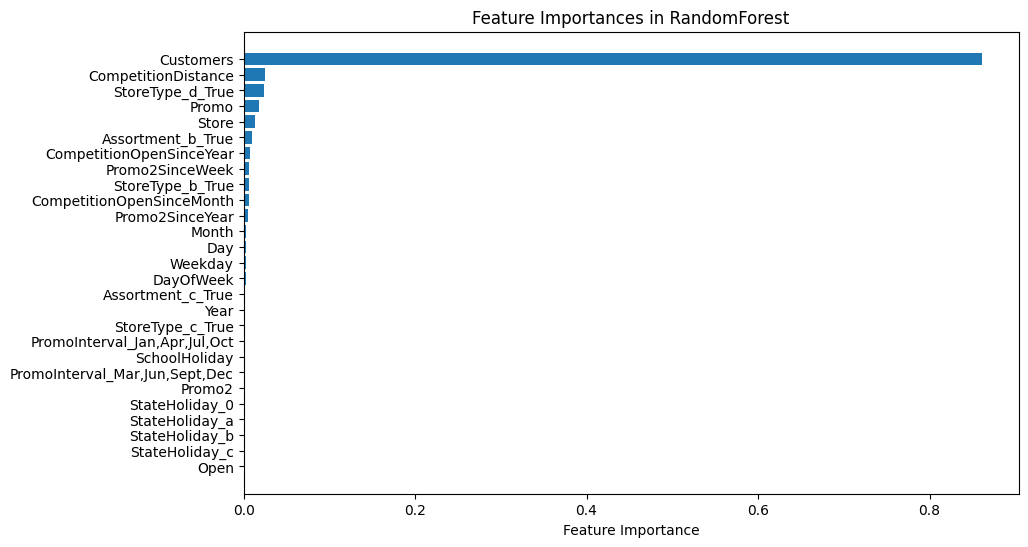

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances
feature_importances = model_pipeline.named_steps['regressor'].feature_importances_

# Get feature names after scaling and one-hot encoding
feature_names = X_train.columns

# Sort feature importances and plot them
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importances in RandomForest")
plt.show()

# Optionally log the top features
top_features = feature_names[sorted_idx][-5:]
logging.info(f"Top 5 important features: {top_features}")


## Step 4: Serialize the Model
Save your model for future use.

In [20]:
import joblib

joblib.dump(model_pipeline, 'data/sales_model.pkl')
print(f"Model saved in data folder")
logging.info("Serialize the model.")

Model saved in data folder
